# Compare modern model with custom cnn

In [1]:
import os
import random
import time
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16, vgg16
from tensorflow.keras.applications import VGG19, vgg19
from tensorflow.keras.applications import ResNet50, resnet50
from tensorflow.keras.applications import InceptionV3, inception_v3
from tensorflow.keras.applications import Xception, xception
from tensorflow.keras.applications import EfficientNetB0, efficientnet


classes = ['cats', 'dogs', 'panda']

# Collect all images and labels
all_images = []
labels = []
for cls in classes:
    cls_dir = os.path.join(data_dir, cls)
    imgs = [os.path.join(cls_dir, f) for f in os.listdir(cls_dir) if f.lower().endswith(('.jpg', '.jpeg'))]
    
    all_images.extend(imgs)
    labels.extend([cls] * len(imgs))

# Split train/test
train_images, val_images, train_labels, val_labels = train_test_split(
    all_images, labels, test_size=500, stratify=labels, random_state=42
)


def load_data(images, labels, input_shape, preprocess_func):
    X = []
    y = []
    class_to_int = {'cats': 0, 'dogs': 1, 'panda': 2}
    for img_path, lbl in zip(images, labels):
        img = image.load_img(img_path, target_size=input_shape[:2])
        img_arr = image.img_to_array(img)
        img_arr = preprocess_func(np.expand_dims(img_arr, axis=0))[0]
        X.append(img_arr)
        y.append(class_to_int[lbl])
    X = np.array(X)
    y = keras.utils.to_categorical(np.array(y), 3)
    return X, y

# Function to build pretrained model
def build_pretrained_model(base_model_class, preprocess_func, input_shape=(224, 224, 3), model_name=''):
    start_time = time.time()
    base_model = base_model_class(weights='imagenet', include_top=False, input_shape=input_shape)
    load_time = time.time() - start_time
    
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(256, activation='relu')(x)
    predictions = layers.Dense(3, activation='softmax')(x)
    
    model = models.Model(inputs=base_model.input, outputs=predictions)
    
    # Freeze base layers
    for layer in base_model.layers:
        layer.trainable = False
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model, load_time

# Function to build custom CNN
def build_custom_cnn(input_shape=(224, 224, 3)):
    start_time = time.time()
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(3, activation='softmax')
    ])
    load_time = time.time() - start_time
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model, load_time

# List of models 
pretrained_models = [
    {'class': VGG16, 'preprocess': vgg16.preprocess_input, 'shape': (224, 224, 3), 'name': 'VGG16'},
    {'class': VGG19, 'preprocess': vgg19.preprocess_input, 'shape': (224, 224, 3), 'name': 'VGG19'},
    {'class': ResNet50, 'preprocess': resnet50.preprocess_input, 'shape': (224, 224, 3), 'name': 'ResNet50'},
    {'class': InceptionV3, 'preprocess': inception_v3.preprocess_input, 'shape': (299, 299, 3), 'name': 'InceptionV3'},
    {'class': Xception, 'preprocess': xception.preprocess_input, 'shape': (299, 299, 3), 'name': 'Xception'},
    {'class': EfficientNetB0, 'preprocess': efficientnet.preprocess_input, 'shape': (224, 224, 3), 'name': 'EfficientNetB0'}
]

results = {}

for m in pretrained_models:
    print(f"Processing {m['name']}...")
    X_train, y_train = load_data(train_images, train_labels, m['shape'], m['preprocess'])
    X_val, y_val = load_data(val_images, val_labels, m['shape'], m['preprocess'])
    
    # Build model
    model, load_time = build_pretrained_model(m['class'], m['preprocess'], m['shape'], m['name'])
    
    # Train
    model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=1)
    
    # Evaluate accuracy
    _, acc = model.evaluate(X_val, y_val, verbose=0)
    
    # Measure predict time
    start_time = time.time()
    preds = model.predict(X_val)
    predict_time_avg = (time.time() - start_time) / len(X_val)
    
    results[m['name']] = {
        'accuracy': acc,
        'load_time': load_time,
        'predict_time_avg': predict_time_avg
    }

# Train and evaluate custom CNN
print("Processing Custom CNN...")
# Load data for custom (rescale 0-1)
custom_preprocess = lambda x: x / 255.0
X_train_custom, y_train_custom = load_data(train_images, train_labels, (224, 224, 3), custom_preprocess)
X_val_custom, y_val_custom = load_data(val_images, val_labels, (224, 224, 3), custom_preprocess)

custom_model, custom_load_time = build_custom_cnn()

custom_model.fit(X_train_custom, y_train_custom, epochs=5, batch_size=32, verbose=1)

_, custom_acc = custom_model.evaluate(X_val_custom, y_val_custom, verbose=0)

start_time = time.time()
custom_preds = custom_model.predict(X_val_custom)
custom_predict_time_avg = (time.time() - start_time) / len(X_val_custom)

results['Custom CNN'] = {
    'accuracy': custom_acc,
    'load_time': custom_load_time,
    'predict_time_avg': custom_predict_time_avg
}

import pandas as pd
df_results = pd.DataFrame.from_dict(results, orient='index')
print(df_results)


2025-09-24 15:55:39.227834: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758729339.414245      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758729339.463109      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Processing VGG16...


I0000 00:00:1758729386.073595      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5


I0000 00:00:1758729393.686551      95 service.cc:148] XLA service 0x7cfeac00d3b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758729393.687297      95 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1758729394.044717      95 cuda_dnn.cc:529] Loaded cuDNN version 90300


 2/79 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - accuracy: 0.4766 - loss: 6.3664  

I0000 00:00:1758729401.937315      95 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


79/79 ━━━━━━━━━━━━━━━━━━━━ 18s 101ms/step - accuracy: 0.8378 - loss: 1.6573
Epoch 2/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - accuracy: 0.9910 - loss: 0.0336
Epoch 3/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.9945 - loss: 0.0143
Epoch 4/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - accuracy: 0.9957 - loss: 0.0113
Epoch 5/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - accuracy: 0.9996 - loss: 0.0016
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step
Processing VGG19...
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - accuracy: 0.8849 - loss: 0.6667
Epoch 2/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.9938 - loss: 0.0244
Epoch 3/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.9946 - loss: 0.0163
Epoch 4/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - accuracy: 0.9999 - loss: 0.0023
Epoch 5/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - accuracy: 0.9915 - loss: 0.0199
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step
Processing Res

E0000 00:00:1758729774.374485      97 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758729774.611562      97 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758729775.723418      97 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-24 16:02:55.872302: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=2} for conv (f32[20,256,74,74]{3,2,1,0}, u8[0]{0}) custom-call(f32[20,256,74,74]{3,2,1,0}, f32[256,256,1,1]{3,2,1,0}), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result

16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 340ms/step
Processing EfficientNetB0...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 38s 141ms/step - accuracy: 0.9418 - loss: 0.1629
Epoch 2/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.9960 - loss: 0.0094
Epoch 3/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.9986 - loss: 0.0058
Epoch 4/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.9999 - loss: 0.0013
Epoch 5/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.9995 - loss: 0.0014
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 459ms/step
Processing Custom CNN...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - accuracy: 0.4434 - loss: 1.4198
Epoch 2/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.6021 - loss: 0.7334
Epoch 3/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.7172 - loss: 0.5723
Epoch 4/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.7696 - loss: 0.4870
Epoch 5/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.8349 - loss: 0.3846
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
                accuracy  load_time  predict_time_avg
VGG16              0.986   2.510566          0.006252
VGG19              0.980   0.813637          0.007584
ResNet50           0.984   1.667593          0.019860
InceptionV3        0.994   2.091758          0.030289
Xception           0.996   1.421318          0.019405
EfficientNetB0     0.992   1.387279          0.028963
Custom CNN         0.730   0.038686          0.003319


# Transfer Learning Tensorflow

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
Số lượng mẫu huấn luyện: 9305
Số lượng mẫu validation: 2326
Số lượng mẫu kiểm tra: 2326

Hiển thị một số ảnh gốc từ tập huấn luyện:


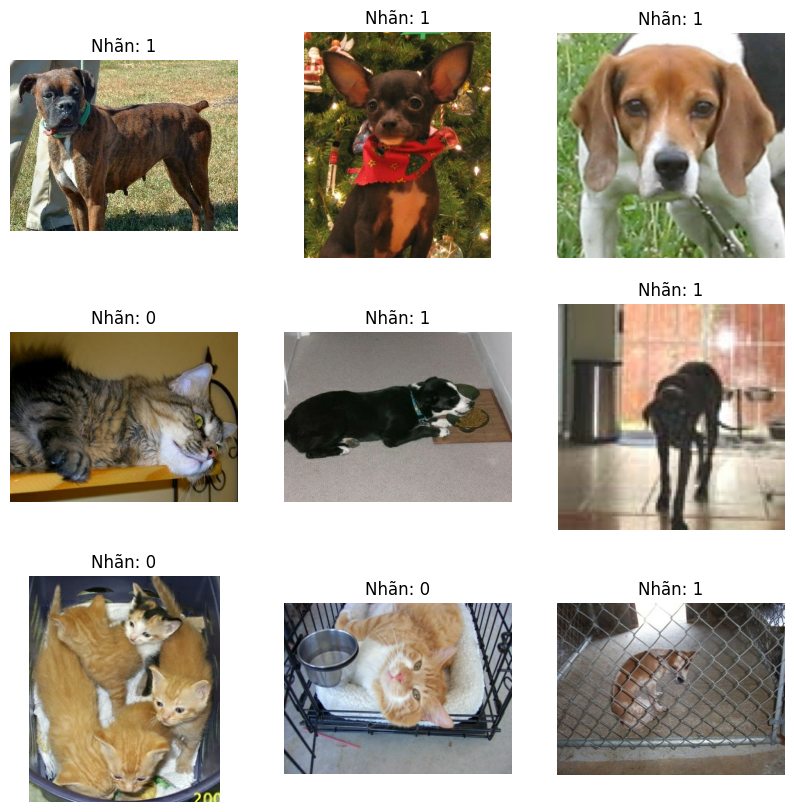


Hiển thị một số ảnh sau khi tăng cường dữ liệu:


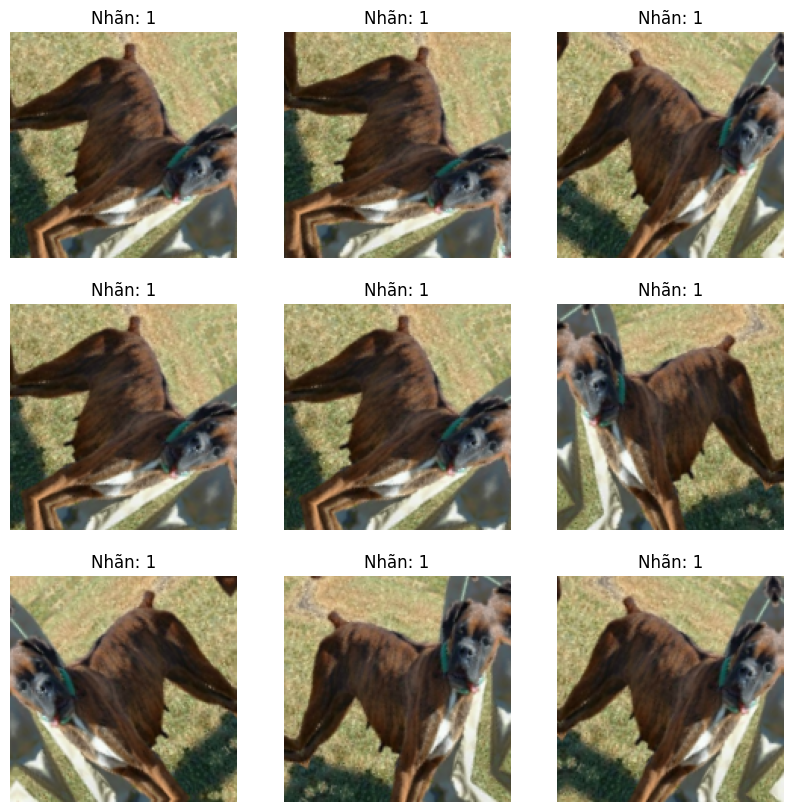


Kiến trúc mô hình trước khi fine-tuning (chỉ các lớp trên cùng được huấn luyện):


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_8 (InputLayer)  │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ rescaling_2 (Rescaling)     │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ xception (Functional)       │ (None, 5, 5, 2048)    │ 20,861,480 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d_6  │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 2048)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_14 (Dense)            │ (None, 1)             │      2,049 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 20,863,529 (79.59 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 20,861,480 (79.58 MB)


Bắt đầu huấn luyện các lớp trên cùng (top layer)...
Epoch 1/2
146/146 ━━━━━━━━━━━━━━━━━━━━ 62s 340ms/step - binary_accuracy: 0.8668 - loss: 0.2826 - val_binary_accuracy: 0.9678 - val_loss: 0.0881
Epoch 2/2
146/146 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - binary_accuracy: 0.9502 - loss: 0.1246 - val_binary_accuracy: 0.9695 - val_loss: 0.0798

Kiến trúc mô hình sau khi mở khóa để fine-tuning:


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_8 (InputLayer)  │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ rescaling_2 (Rescaling)     │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ xception (Functional)       │ (None, 5, 5, 2048)    │ 20,861,480 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d_6  │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 2048)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_14 (Dense)            │ (None, 1)             │      2,049 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 20,867,629 (79.60 MB)

 Trainable params: 20,809,001 (79.38 MB)

 Non-trainable params: 54,528 (213.00 KB)

 Optimizer params: 4,100 (16.02 KB)


Bắt đầu tinh chỉnh (fine-tuning) toàn bộ mô hình...
Epoch 1/10


E0000 00:00:1758731562.419981      96 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758731562.624339      96 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758731562.824896      96 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758731563.828038      96 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758731564.016519      96 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

145/146 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - binary_accuracy: 0.8536 - loss: 0.3688

E0000 00:00:1758731611.856686      95 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758731612.049578      95 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758731612.649754      95 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758731612.836798      95 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758731613.374934      95 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

146/146 ━━━━━━━━━━━━━━━━━━━━ 111s 373ms/step - binary_accuracy: 0.8539 - loss: 0.3680 - val_binary_accuracy: 0.9613 - val_loss: 0.1048
Epoch 2/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 34s 230ms/step - binary_accuracy: 0.9311 - loss: 0.1866 - val_binary_accuracy: 0.9613 - val_loss: 0.0995
Epoch 3/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 34s 230ms/step - binary_accuracy: 0.9567 - loss: 0.1149 - val_binary_accuracy: 0.9643 - val_loss: 0.0923
Epoch 4/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 34s 230ms/step - binary_accuracy: 0.9783 - loss: 0.0720 - val_binary_accuracy: 0.9652 - val_loss: 0.0887
Epoch 5/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 34s 230ms/step - binary_accuracy: 0.9883 - loss: 0.0466 - val_binary_accuracy: 0.9665 - val_loss: 0.0866
Epoch 6/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 34s 230ms/step - binary_accuracy: 0.9945 - loss: 0.0290 - val_binary_accuracy: 0.9673 - val_loss: 0.0858
Epoch 7/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 34s 230ms/step - binary_accuracy: 0.9972 - loss: 0.0186 - val_binary_accuracy: 0.9669 - val_loss: 0.

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

tfds.disable_progress_bar()
train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,
)

print(f"Số lượng mẫu huấn luyện: {train_ds.cardinality()}")
print(f"Số lượng mẫu validation: {validation_ds.cardinality()}")
print(f"Số lượng mẫu kiểm tra: {test_ds.cardinality()}")

print("\nHiển thị một số ảnh gốc từ tập huấn luyện:")
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(f"Nhãn: {int(label)}")
    plt.axis("off")
plt.show()

IMG_SIZE = 150
resize_fn = keras.layers.Resizing(IMG_SIZE, IMG_SIZE)

train_ds = train_ds.map(lambda x, y: (resize_fn(x), y))
validation_ds = validation_ds.map(lambda x, y: (resize_fn(x), y))
test_ds = test_ds.map(lambda x, y: (resize_fn(x), y))

augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]

def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x

train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

BATCH_SIZE = 64
train_ds = train_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE).cache()
validation_ds = validation_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE).cache()
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE).cache()

print("\nHiển thị một số ảnh sau khi tăng cường dữ liệu:")
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(np.expand_dims(first_image, 0))
        plt.imshow(np.array(augmented_image[0]).astype("int32"))
        plt.title(f"Nhãn: {int(labels[0])}")
        plt.axis("off")
    plt.show()

base_model = keras.applications.Xception(
    weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
)

base_model.trainable = False

inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

print("\nKiến trúc mô hình trước khi fine-tuning (chỉ các lớp trên cùng được huấn luyện):")
model.summary(show_trainable=True)

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs_top_layer = 2
print("\nBắt đầu huấn luyện các lớp trên cùng (top layer)...")
history_top = model.fit(train_ds, epochs=epochs_top_layer, validation_data=validation_ds)

base_model.trainable = True

print("\nKiến trúc mô hình sau khi mở khóa để fine-tuning:")
model.summary(show_trainable=True)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs_fine_tuning = 10
print("\nBắt đầu tinh chỉnh (fine-tuning) toàn bộ mô hình...")
history_fine_tune = model.fit(train_ds, epochs=epochs_fine_tuning, validation_data=validation_ds)

print("\nĐang đánh giá mô hình trên tập dữ liệu test...")
test_loss, test_acc = model.evaluate(test_ds)
print(f"\nĐộ chính xác trên tập test: {test_acc:.4f}")
print(f"Loss trên tập test: {test_loss:.4f}")


# Transfer Learning Torch

Using device: cuda
Classes found: ['animals', 'images']
Number of training samples: 4804
Number of validation samples: 1202


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 178MB/s] 
/tmp/ipykernel_36/676923170.py:191: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)


Freeze strategy: Unfreezing last 1 block(s) + classifier.
Trainable params: 8,394,754 / 11,177,538 (75.10%)

Bắt đầu huấn luyện...


Training:   0%|          | 0/151 [00:00<?, ?it/s]/tmp/ipykernel_36/676923170.py:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Epoch 01/10 | Train Loss: 0.0099 Acc: 0.9985 | Val Loss: 0.0003 Acc: 1.0000
  -> New best model saved to outputs/resnet18_partial.pt with accuracy: 1.0000


Epoch 02/10 | Train Loss: 0.0036 Acc: 0.9994 | Val Loss: 0.0002 Acc: 1.0000


Epoch 03/10 | Train Loss: 0.0039 Acc: 0.9992 | Val Loss: 0.0002 Acc: 1.0000


Epoch 04/10 | Train Loss: 0.0028 Acc: 0.9992 | Val Loss: 0.0001 Acc: 1.0000


Epoch 05/10 | Train Loss: 0.0013 Acc: 0.9994 | Val Loss: 0.0001 Acc: 1.0000


Epoch 06/10 | Train Loss: 0.0012 Acc: 0.9992 | Val Loss: 0.0000 Acc: 1.0000


Epoch 07/10 | Train Loss: 0.0021 Acc: 0.9996 | Val Loss: 0.0001 Acc: 1.0000


Epoch 08/10 | Train Loss: 0.0008 Acc: 0.9998 | Val Loss: 0.0001 Acc: 1.0000


Epoch 09/10 | Train Loss: 0.0009 Acc: 0.9992 | Val Loss: 0.0001 Acc: 1.0000


Epoch 10/10 | Train Loss: 0.0014 Acc: 0.9994 | Val Loss: 0.0001 Acc: 1.0000

Huấn luyện hoàn tất trong 4m 16s
Độ chính xác validation tốt nhất: 1.0000


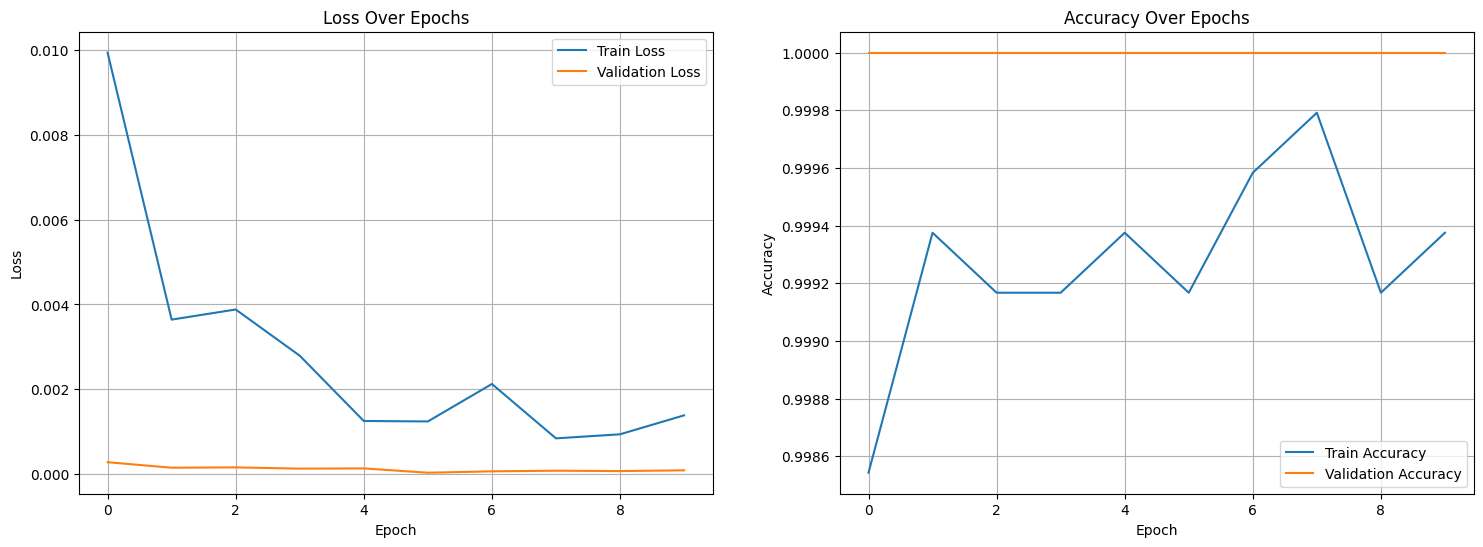

Tải model tốt nhất từ: outputs/resnet18_partial.pt



Classification Report:



ValueError: Number of classes, 1, does not match size of target_names, 2. Try specifying the labels parameter

In [1]:
import os
from pathlib import Path
from PIL import Image
import numpy as np
from pathlib import Path

DATA_ROOT = Path("/kaggle/input/animal-image-datasetdog-cat-and-panda") 
NEED_RANDOM_SPLIT = True     
TRAIN_RATIO = 0.8            
RANDOM_SEED = 42             

MODEL_NAME = "resnet18"      
IMAGE_SIZE = 224             
BATCH_SIZE = 32              
NUM_EPOCHS = 10              

LR_BACKBONE = 1e-4           
LR_CLASSIFIER = 1e-3         

FREEZE_STRATEGY = "partial"  
UNFREEZE_LAST_BLOCKS = 1     

USE_AMP = True               
NUM_WORKERS = 2              
OUTPUT_DIR = Path("outputs")
CHECKPOINT_PATH = OUTPUT_DIR / f"{MODEL_NAME}_{FREEZE_STRATEGY}.pt"

# Tạo thư mục output nếu chưa có
OUTPUT_DIR.mkdir(exist_ok=True)



import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


# Chuẩn hóa theo ImageNet là bắt buộc khi dùng model pretrained từ ImageNet
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    normalize,
])

val_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE + 32),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    normalize,
])


def build_dataloaders(root, need_split, train_ratio, seed, train_tf, val_tf, batch_size, num_workers):
    if need_split:
        full_dataset = ImageFolder(root=root)
        
        # Chia tập
        total_size = len(full_dataset)
        train_size = int(train_ratio * total_size)
        val_size = total_size - train_size
        
        generator = torch.Generator().manual_seed(seed)
        train_subset, val_subset = random_split(full_dataset, [train_size, val_size], generator=generator)
        
        # Gán transform cho từng tập con
        class CustomSubset(Dataset):
            def __init__(self, subset, transform=None):
                self.subset = subset
                self.transform = transform
            def __getitem__(self, index):
                x, y = self.subset[index]
                if self.transform:
                    x = self.transform(x)
                return x, y
            def __len__(self):
                return len(self.subset)
                
        train_dataset = CustomSubset(train_subset, transform=train_tf)
        val_dataset = CustomSubset(val_subset, transform=val_tf)
        class_names = full_dataset.classes
    else:
        train_dataset = ImageFolder(root=root / "train", transform=train_tf)
        val_dataset = ImageFolder(root=root / "val", transform=val_tf)
        class_names = train_dataset.classes
        
    print(f"Classes found: {class_names}")
    print(f"Number of training samples: {len(train_dataset)}")
    print(f"Number of validation samples: {len(val_dataset)}")
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    
    return train_loader, val_loader, class_names

train_loader, val_loader, class_names = build_dataloaders(
    DATA_ROOT, NEED_RANDOM_SPLIT, TRAIN_RATIO, RANDOM_SEED, 
    train_transform, val_transform, BATCH_SIZE, NUM_WORKERS
)
num_classes = len(class_names)


def build_model(model_name, num_classes):
    model = models.get_model(model_name, weights='DEFAULT')
    
    # Thay thế lớp phân loại cuối cùng
    if "resnet" in model_name or "resnext" in model_name:
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, num_classes)
        classifier_params = model.fc.parameters()
    elif "efficientnet" in model_name or "mobilenet" in model_name:
        in_features = model.classifier[-1].in_features
        model.classifier[-1] = nn.Linear(in_features, num_classes)
        classifier_params = model.classifier.parameters()
    else:
        raise ValueError(f"Model {model_name} not supported for automatic head replacement.")
        
    return model, classifier_params

model, classifier_params = build_model(MODEL_NAME, num_classes)
model = model.to(device)


def set_freeze_strategy(model, model_name, strategy, unfreeze_blocks):
    # Đóng băng toàn bộ
    for param in model.parameters():
        param.requires_grad = False
        
    # Mở lớp classifier
    if "resnet" in model_name or "resnext" in model_name:
        for param in model.fc.parameters():
            param.requires_grad = True
    elif "efficientnet" in model_name or "mobilenet" in model_name:
        for param in model.classifier.parameters():
            param.requires_grad = True

    if strategy == "all_frozen":
        print("Freeze strategy: Only classifier is trainable.")
    
    elif strategy == "partial":
        print(f"Freeze strategy: Unfreezing last {unfreeze_blocks} block(s) + classifier.")
        if "resnet" in model_name:
            layers_to_unfreeze = [model.layer4, model.layer3, model.layer2, model.layer1]
            for i in range(unfreeze_blocks):
                if i < len(layers_to_unfreeze):
                    for param in layers_to_unfreeze[i].parameters():
                        param.requires_grad = True
    
    elif strategy == "none":
        print("Freeze strategy: Full fine-tuning (all layers trainable).")
        for param in model.parameters():
            param.requires_grad = True
    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Trainable params: {trainable_params:,} / {total_params:,} ({100. * trainable_params / total_params:.2f}%)")

set_freeze_strategy(model, MODEL_NAME, FREEZE_STRATEGY, UNFREEZE_LAST_BLOCKS)


def get_param_groups(model, classifier_params, lr_backbone, lr_classifier):
    classifier_param_ids = {id(p) for p in classifier_params}
    backbone_params = [p for p in model.parameters() if id(p) not in classifier_param_ids and p.requires_grad]
    classifier_params_trainable = [p for p in model.parameters() if id(p) in classifier_param_ids and p.requires_grad]
    
    param_groups = [
        {'params': backbone_params, 'lr': lr_backbone},
        {'params': classifier_params_trainable, 'lr': lr_classifier},
    ]
    return param_groups

param_groups = get_param_groups(model, classifier_params, LR_BACKBONE, LR_CLASSIFIER)

optimizer = optim.AdamW(param_groups, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS - 1)
scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)


def train_one_epoch(model, loader, optimizer, criterion, device, scaler, use_amp):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    
    pbar = tqdm(loader, desc="Training", leave=False)
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        with torch.cuda.amp.autocast(enabled=use_amp):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
        pbar.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = running_corrects.double() / len(loader.dataset)
    return epoch_loss, epoch_acc.item()

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        pbar = tqdm(loader, desc="Evaluating", leave=False)
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss = running_loss / len(loader.dataset)
    val_acc = running_corrects.double() / len(loader.dataset)
    return val_loss, val_acc.item(), all_labels, all_preds

# --- Main training loop ---
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val_acc = 0.0

print("\nBắt đầu huấn luyện...")
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device, scaler, USE_AMP)
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion, device)
    scheduler.step()
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f"Epoch {epoch+1:02d}/{NUM_EPOCHS} | Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'model_state_dict': model.state_dict(),
            'class_names': class_names,
            'model_name': MODEL_NAME,
        }, CHECKPOINT_PATH)
        print(f"  -> New best model saved to {CHECKPOINT_PATH} with accuracy: {best_val_acc:.4f}")

total_time = time.time() - start_time
print(f"\nHuấn luyện hoàn tất trong {total_time // 60:.0f}m {total_time % 60:.0f}s")
print(f"Độ chính xác validation tốt nhất: {best_val_acc:.4f}")



def plot_learning_curves(history, epochs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    
    # Plot Loss
    ax1.plot(range(epochs), history['train_loss'], label='Train Loss')
    ax1.plot(range(epochs), history['val_loss'], label='Validation Loss')
    ax1.set_title('Loss Over Epochs')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot Accuracy
    ax2.plot(range(epochs), history['train_acc'], label='Train Accuracy')
    ax2.plot(range(epochs), history['val_acc'], label='Validation Accuracy')
    ax2.set_title('Accuracy Over Epochs')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.show()

plot_learning_curves(history, NUM_EPOCHS)


# Tải lại model tốt nhất để đánh giá
print(f"Tải model tốt nhất từ: {CHECKPOINT_PATH}")
checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)
model, _ = build_model(checkpoint['model_name'], len(checkpoint['class_names']))
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)

# Đánh giá trên tập validation
_, _, y_true, y_pred = evaluate(model, val_loader, criterion, device)

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


def predict_image(image_path, model, class_names, transform, device):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        confidence, predicted_idx = torch.max(probabilities, 1)
        
    predicted_label = class_names[predicted_idx.item()]
    return predicted_label, confidence.item()

# Tạo một ảnh demo để dự đoán
demo_img_path = str(list((DATA_ROOT / "panda").glob("*.jpg"))[0])

img_array = np.random.randint(0, 255, size=(250, 250, 3), dtype=np.uint8)
Image.fromarray(img_array).save(demo_img_path)

# Dự đoán
predicted_label, confidence = predict_image(demo_img_path, model, class_names, val_transform, device)
print(f"\nDự đoán cho ảnh '{demo_img_path}':")
print(f"  -> Lớp: {predicted_label}")
print(f"  -> Độ tự tin: {confidence:.4f}")